The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install mxnet-cu100
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl


# Neural Network Inference

:label:`ch_from_mxnet`


You have seen how to implement and compile a simple vector addition operator in :numref:`ch_vector_add`. Now we will make a big jump to compile a whole pre-trained neural network, which consists of a set of operators, to run the inference.

In [1]:
import numpy as np
import mxnet as mx
from PIL import Image
import tvm
from tvm import relay

Here three additional modules are imported compared to the previous chapter. We will use `PIL` to read images, `mxnet` to obtain pre-trained neural networks, and the `relay` module :cite:`Roesch.Lyubomirsky.Kirisame.ea.2019` in TVM to convert and optimize a neural network.
`Relay` is the high-level intermediate representation (IR) in TVM to represent a neural network.

## Obtaining Pre-trained Models

A pre-trained model means a neural network with parameters trained on a data set. Here we download and load a ResNet-18 model by specifying `pretrained=True` from MXNet's model zoo :cite:`Chen.Li.Li.ea.2015`. If you want to know details about this model, please refer to [Chapter 7.6 in D2L](http://d2l.ai/chapter_convolutional-modern/resnet.html). You can find more models on the [MXNet model zoo](https://mxnet.apache.org/api/python/docs/api/gluon/model_zoo/index.html) page, or refer to [GluonCV](https://gluon-cv.mxnet.io/model_zoo/index.html) and [GluonNLP](http://gluon-nlp.mxnet.io/model_zoo/index.html) for more computer vision and natural language models.

In [2]:
model = mx.gluon.model_zoo.vision.resnet18_v2(pretrained=True)
len(model.features), model.output

(13, Dense(512 -> 1000, linear))

The loaded model is trained on the Imagenet 1K dataset, which contains around 1 million natural object images among 1000 classes. The model has two parts, the main body part `model.features` contains 13 blocks, and the output layer is a dense layer with 1000 outputs.

The following code block loads the text labels for each class in the Imagenet dataset.

In [3]:
with open('../data/imagenet1k_labels.txt') as f:
    labels = eval(f.read())

## Pre-processing Data

We first read a sample image. It is resized to the size, i.e. 224 px width and height, which we used to train the neural network.

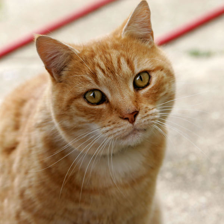

In [4]:
image = Image.open('../data/cat.jpg').resize((224, 224))
image

According to the [model zoo page](https://mxnet.apache.org/api/python/docs/api/gluon/model_zoo/index.html). Image pixes are normalized on each color channel, and the data layout is `(batch, RGB channels, height, width)`. The following function transforms the input image to satisfy the requirement.

In [5]:
# Save to the d2ltvm package
def image_preprocessing(image):
    image = np.array(image) - np.array([123., 117., 104.])
    image /= np.array([58.395, 57.12, 57.375])
    image = image.transpose((2, 0, 1))
    image = image[np.newaxis, :]
    return image.astype('float32')

x = image_preprocessing(image)
x.shape

(1, 3, 224, 224)

## Compile Pre-trained Models

To compile a model, we first express the MXNet model in Relay IR, which the `from_mxnet` method could help.
In the method, we provide the model with the input data shape. Some neural networks may require some dimension(s) of the data shape to be determined later.
However, in ResNet model the data shape is fixed, which makes it easier for the compiler to achieve high performance.
We will mostly stick to fixed data shape in the book. We only touch the dynamic data shape (i.e. some dimension(s) to be determined in runtime) in very late chapters.

In [6]:
relay_mod, relay_params = relay.frontend.from_mxnet(model, {'data': x.shape})
type(relay_mod), type(relay_params)

(tvm.relay.module.Module, dict)

This method will return the program `relay_mod`, which is a `relay` module, and a dictionary of parameters `relay_params` that maps a string key to a TVM ndarray. Next, we lower the module to some lower-level IR which can be consumed by `llvm` backend. [LLVM](https://en.wikipedia.org/wiki/LLVM) defines an IR that has been adopted by multiple programming languages. The LLVM compiler is then able to compile the generated programs into machine codes for CPUs. We have already used it to compile the vector addition operator in :numref:`ch_vector_add`, despite that we didn't explicitly specify it.

In addition, we set the optimization level to the highest level 3. You may get warning messages that not every operator is well optimized, you can ignore it for now. We will get back to it later.

In [7]:
target = 'llvm'
with relay.build_config(opt_level=3):
    graph, mod, params = relay.build(relay_mod, target, params=relay_params)

Cannot find config for target=llvm, workload=('dense', (1, 512, 'float32'), (1000, 512, 'float32'), 0, 'float32'). A fallback configuration is used, which may bring great performance regression.


The compiled module has three parts: `graph` is a json string described the neural network, `mod` is a library that contains all compiled operators used to run the inference, and `params` is a dictionary mapping parameter name to weights.

In [8]:
type(graph), type(mod), type(params)

(str, tvm.module.Module, dict)

You can view `mod` as a TVM module we already seen in :numref:`ch_vector_add`.

## Inference

Now we can create a runtime to run the model inference, namely the forward pass of a neural network. Creating the runtime needs the neural network definition in json (i.e. `graph`) and the library that contains machine code of compiled operators (i.e. `mod`), with a device context that can be constructed from the target. The device is CPU here, specified by `llvm`. Next we load the parameters with `set_input` and run the workload by feeding the input data. Since this network has a single output layer, we can obtain it, a `(1, 1000)` shape matrix, by `get_output(0)`. The final output is a 1000-length NumPy vector.

In [9]:
ctx = tvm.context(target)
rt = tvm.contrib.graph_runtime.create(graph, mod, ctx)
rt.set_input(**params)
rt.run(data=tvm.nd.array(x))
scores = rt.get_output(0).asnumpy()[0]
scores.shape

(1000,)

The vector contains the predicted confidence score for each class. Note that the pre-trained model doesn't have the [softmax](https://en.wikipedia.org/wiki/Softmax_function) operator, so these scores are not mapped into probabilities in (0, 1). Now we can find the two largest scores and report their labels.

In [10]:
a = np.argsort(scores)[-1:-5:-1]
labels[a[0]], labels[a[1]]

('tiger cat', 'Egyptian cat')

## Saving the Compiled Library

We can save the output of `relay.build` in disk to reuse them later. The following code block saves the json string, library, and parameters.

In [11]:
!rm -rf resnet18*

name = 'resnet18'
graph_fn, mod_fn, params_fn = [name+ext for ext in ('.json','.tar','.params')]
mod.export_library(mod_fn)
with open(graph_fn, 'w') as f:
    f.write(graph)
with open(params_fn, 'wb') as f:
    f.write(relay.save_param_dict(params))

!ls -alht resnet18*

-rw-r--r-- 1 jenkins jenkins  45M Jan 16 03:59 resnet18.params
-rw-r--r-- 1 jenkins jenkins  28K Jan 16 03:59 resnet18.json
-rw-r--r-- 1 jenkins jenkins 148K Jan 16 03:59 resnet18.tar


Now we load the saved module back.

In [12]:
loaded_graph = open(graph_fn).read()
loaded_mod = tvm.module.load(mod_fn)
loaded_params = open(params_fn, "rb").read()

And then construct the runtime as before to verify the results

In [13]:
loaded_rt = tvm.contrib.graph_runtime.create(loaded_graph, loaded_mod, ctx)
loaded_rt.load_params(loaded_params)
loaded_rt.run(data=tvm.nd.array(x))
loaded_scores = loaded_rt.get_output(0).asnumpy()[0]
tvm.testing.assert_allclose(loaded_scores, scores)

## Summary

- We can use `relay` of TVM to convert and compile a neural network into a module for model inference.
- We can save the compiled module into disk to facilitate future deployment.

## [Discussions](https://discuss.tvm.ai/t/getting-started-neural-network-inference/4708)